In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize

In [2]:
# loading json as a table
logins_table = pd.read_json('logins.json')

In [3]:
logins_table.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins_table.shape

(93142, 1)

## Part 1 ‐ Exploratory data analysis

### Aggregate these login counts based on 15­minute time intervals 

In [5]:
logins_table.set_index('login_time', inplace=True)
logins_table['count'] = 1

In [6]:
logins_table.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [10]:
logins_agg = logins_table.resample('15T', how='sum')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


In [11]:
logins_agg.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


### Visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand

In [12]:
import numpy as np
from pandas import read_csv
from matplotlib import pyplot

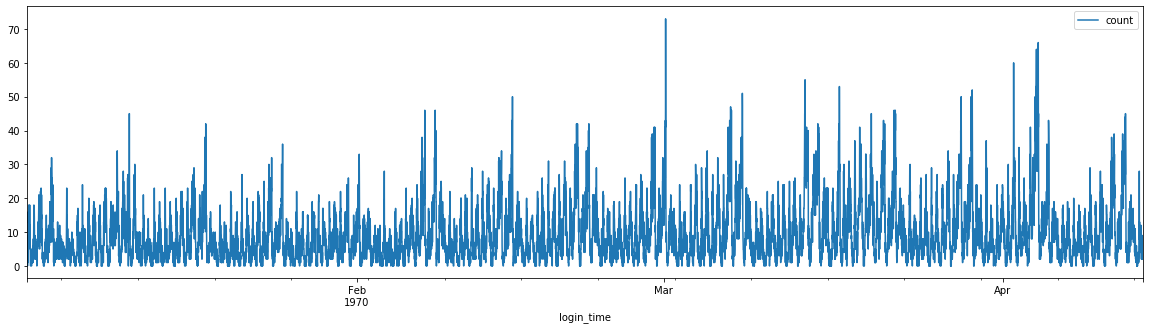

In [23]:
fig = pyplot.figure(figsize = (20,5))
ax = fig.add_subplot(111)
logins_agg.plot(ax=ax)

#### Let's look at the plot for data spanning a week

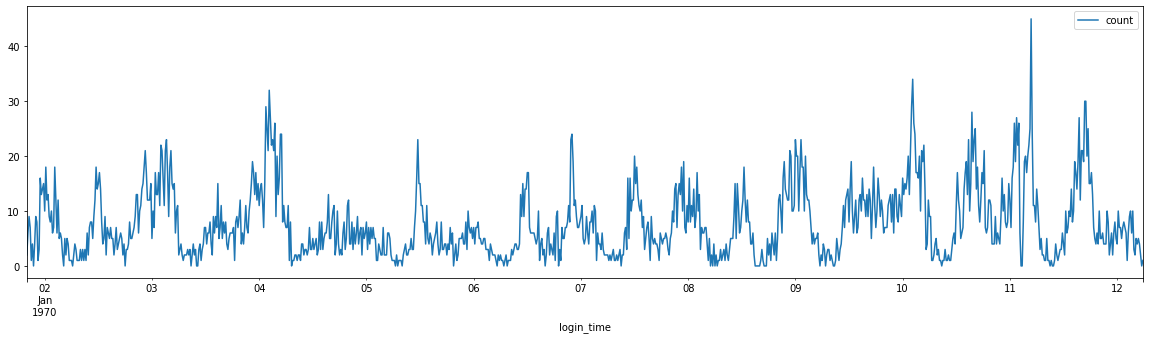

In [26]:
fig = pyplot.figure(figsize = (20,5))
ax = fig.add_subplot(111)
logins_agg[0:1000].plot(ax=ax)

In [27]:
#logins_agg1['week_day'] = logins_agg1['login_time'].apply(get_weekday())

logins_agg['time'] = logins_agg.reset_index()['login_time'].dt.time.tolist()
logins_agg['day_of_week'] = logins_agg.reset_index()['login_time'].dt.dayofweek.tolist()
logins_agg['month'] = logins_agg.reset_index()['login_time'].dt.month.tolist()
logins_agg.reset_index(drop=True, inplace=True)
logins_agg.head()

,count,time,day_of_week,month
0,2,20:00:00,3,1
1,6,20:15:00,3,1
2,9,20:30:00,3,1
3,7,20:45:00,3,1
4,1,21:00:00,3,1


Text(0.5, 1.0, 'Average Login Counts by Time (on any given day)')

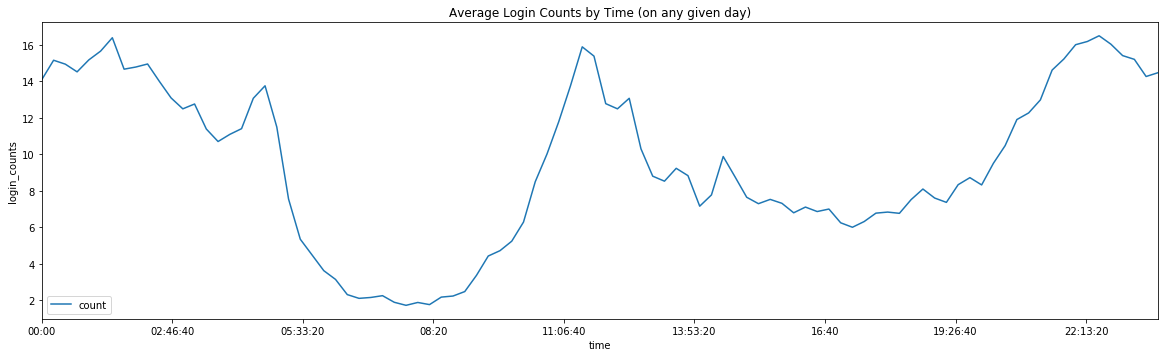

In [28]:
#pyplot.subplots(figsize=(20,20))
fig = pyplot.figure(figsize = (20,12))
ax = fig.add_subplot(211)
logins_agg.groupby(['time']).mean().reset_index().plot(x='time', y='count', ax=ax)
#fig = pyplot.figure()

ax.set_ylabel('login_counts')
ax.set_title('Average Login Counts by Time (on any given day)')
#pyplot.show()

### On any given day, logins are at peak around mid-day and late night

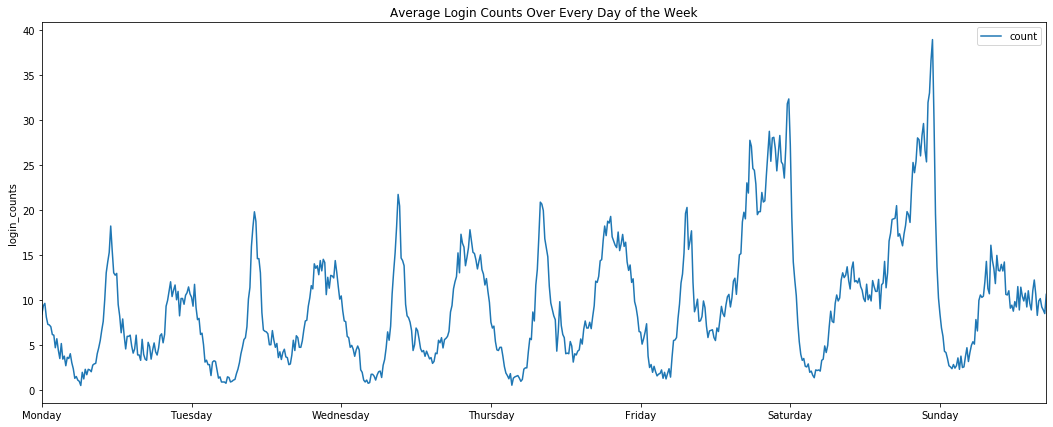

In [34]:
fig, ax = pyplot.subplots(figsize=(18,7))
logins_agg.groupby(['day_of_week', 'time']).mean().reset_index().plot( y='count', ax=ax)
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.set_ylabel('login_counts')
ax.set_title('Average Login Counts Over Every Day of the Week')
pyplot.show()

### Login count is gradually increasing from Monday through Sunday. Weekends record higher logins than weekdays. 

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

#### <font color='blue'> 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Solution: Measure driver engagement during weekends </font>


#### <font color='blue'> 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: </font>

#### <font color='blue'> a. how you will implement the experiment </font>

####  <font color='blue'> b. what statistical test(s) you will conduct to verify the significance of the observation </font>

#### <font color='blue'> c. how you would interpret the results and provide recommendations to the city operations team along with any caveats. </font>

Solution: Calculate number of trips between both cities on the weekends and the money generated through these trips. Calculate howmuch money was refunded to cover tolls between the 2 cities. If the money generated is greater than the cost, the experiment can be considered to be feasible/financially viable. 


## Part 3 ‐ Predictive modeling

In [39]:
#data = pd.read_json('/ultimate_data_challenge.json', orient='split')

In [41]:
import json
with open('ultimate_data_challenge.json', 'r') as datafile:
    data = json.load(datafile)
df = pd.DataFrame(data)

In [42]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [45]:
df.shape

(50000, 12)

In [44]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [47]:
df = df.dropna()

In [48]:
df = df.reset_index(drop = True)

In [50]:
#df.isna().sum()

In [52]:
active_user = []
for i in range(len(df)):
    start_date = pd.Timestamp(df['signup_date'][i]) 
    end_date = start_date + pd.Timedelta('180D')
    active_30daysprior = end_date - pd.Timedelta('30D') #set point 30 days prior
    if active_30daysprior <= pd.Timestamp(df['last_trip_date'][i]) <= end_date:
        active_user.append([1]) 
    else:
        active_user.append([0])

In [53]:
df1 = pd.DataFrame(active_user,columns = ['active_user'])

In [54]:
df1['active_user'].value_counts()

0    29746
1    11699
Name: active_user, dtype: int64

In [57]:
ret = round(11699/ (29746+11699) * 100, 2)
print("Fraction of users retained: ", ret)

Fraction of users retained:  28.23


In [58]:
df2 = pd.concat([df, df1], axis=1)

In [59]:
df2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [60]:
import pycaret
from pycaret.classification import *

In [62]:
df2 = df2.reset_index(drop=True)

In [68]:
df2.dtypes.value_counts()

float64    6
object     4
int64      2
bool       1
dtype: int64

In [69]:
len(df2.columns)

13

In [70]:
len(df2.columns.unique())

13

In [71]:
df2.active_user.dtypes

dtype('int64')

In [63]:
exp1 = setup(data = df2, target = 'active_user')

IntProgress(value=0, description='Processing: ', max=13)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,02:26:43
Status,. . . . . . . . . . . . . . . . . .,Preparing Data for Modeling
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
city,Categorical
trips_in_first_30_days,Numeric
signup_date,Date
avg_rating_of_driver,Numeric
avg_surge,Numeric
last_trip_date,Date
phone,Categorical
surge_pct,Numeric
ultimate_black_user,Categorical
weekday_pct,Numeric


AttributeError: 'float' object has no attribute 'shape'

NameError: name 'traceback' is not defined